# Post-processing

This notebook is a very simple example of how to post-process the output data of the plugin. We use images from the Broad Bioimage Benchmark Collection BBBC047 dataset available on [IDR](https://idr.openmicroscopy.org/webclient/?show=screen-1251) in the Public Domain.

The group of files that can be found in the `../sample_data/data_multiscene` folder were processed using napari-serialcellpose. The output is stored in `../sample_data/data_multiscene/data_out`. In particular we can load from there the summary table:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import skimage
import tifffile

In [5]:
summary = pd.read_csv('../sample_data/data_multiscene/data_out/tables/summary.csv')
summary

,area,intensity_mean-C:0,intensity_mean-C:1,intensity_mean-C:2,intensity_mean-C:3,intensity_mean-C:4,name,image_name,scene
0,3170.0,350.701262,617.777603,685.422082,975.015773,507.933754,cdp2bioactives_h23.ome_scene0_props,cdp2bioactives_h23.ome,0
1,2434.0,285.048069,592.117502,648.852506,1065.069433,504.452342,cdp2bioactives_h23.ome_scene0_props,cdp2bioactives_h23.ome,0
2,3470.0,240.025937,596.144669,551.363112,930.624784,444.520461,cdp2bioactives_h23.ome_scene0_props,cdp2bioactives_h23.ome,0
3,3008.0,248.990691,474.194149,500.905585,731.343418,417.153590,cdp2bioactives_h23.ome_scene0_props,cdp2bioactives_h23.ome,0
4,3013.0,250.854298,491.552273,518.640558,717.603053,450.623631,cdp2bioactives_h23.ome_scene0_props,cdp2bioactives_h23.ome,0
...,...,...,...,...,...,...,...,...,...
859,3152.0,311.683058,516.481916,594.805203,919.750635,480.696383,cdp2bioactives_h23.ome_scene3_props,cdp2bioactives_h23.ome,3
860,1375.0,677.002182,909.606545,1169.366545,1449.194909,705.314909,cdp2bioactives_h23.ome_scene3_props,cdp2bioactives_h23.ome,3
861,2610.0,418.725287,727.285057,814.003065,1232.711111,588.915709,cdp2bioactives_h23.ome_scene3_props,cdp2bioactives_h23.ome,3
862,1775.0,334.572958,533.143662,645.069296,912.615211,510.241690,cdp2bioactives_h23.ome_scene3_props,cdp2bioactives_h23.ome,3


We see that 5 channels were processed and their mean intensity recovered. We also see that images come from difference "scenes" belonging to a given well (H15 or H23).

## Thresholding

With this table we can now select specific parts of our data for further analysis. For example, we may want to discard cells based on  their size. Let's first look at a histogram:

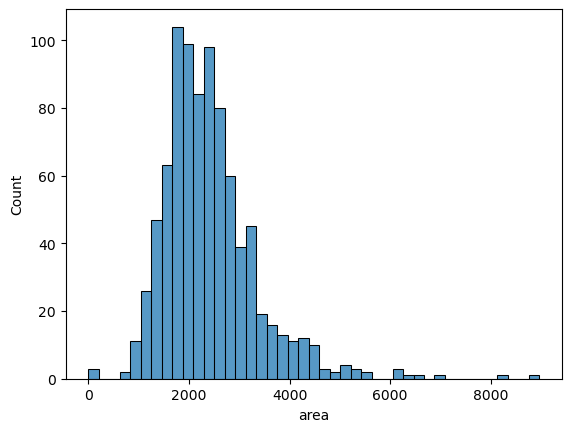

In [6]:
sns.histplot(data=summary, x='area');

We see that we have a few very large cells, probably the result of mis-segmentations. Here we simply remove them but *in general you should always look at the actual data* to make sure you are not removing valuable information. In any case, you should clearly report how you selected your data.

In [7]:
threshold_area = 6000

In [8]:
summary_select = summary[summary['area'] < threshold_area]

Now we can looks at th distribution of intensity in some of the channels:

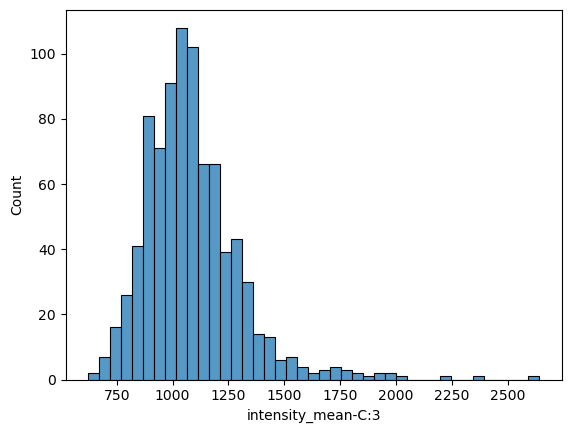

In [9]:
sns.histplot(data=summary_select,x='intensity_mean-C:3');

We see that here too we have some outliers. In principle we can remove those as well, either using a series of conditions or adding all conditions in one selection:

In [10]:
threshold_area = 7000
threshold_intC3 = 1500

summary_select = summary[summary['area'] < threshold_area]
summary_select = summary_select[summary_select['intensity_mean-C:3'] < threshold_intC3]

Based on that selection we can then plot other intensities:

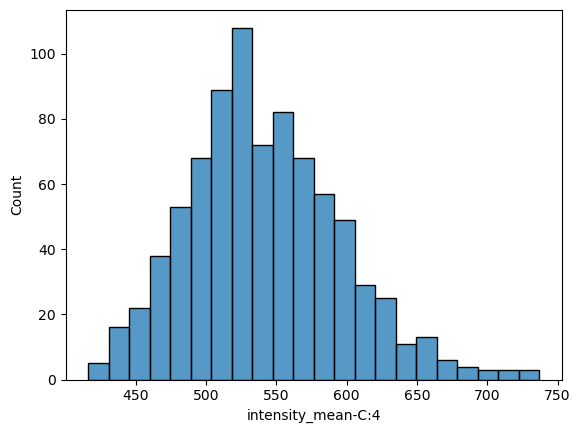

In [11]:
sns.histplot(data=summary_select,x='intensity_mean-C:4');

Given that we have multiple acquisition for the same condition (multiple scenes), we can also use that information to create groups. For example we can make a histogram and group by `image_name` i.e. by well: 

In [12]:
summary_select.head(2)

,area,intensity_mean-C:0,intensity_mean-C:1,intensity_mean-C:2,intensity_mean-C:3,intensity_mean-C:4,name,image_name,scene
0,3170.0,350.701262,617.777603,685.422082,975.015773,507.933754,cdp2bioactives_h23.ome_scene0_props,cdp2bioactives_h23.ome,0
1,2434.0,285.048069,592.117502,648.852506,1065.069433,504.452342,cdp2bioactives_h23.ome_scene0_props,cdp2bioactives_h23.ome,0


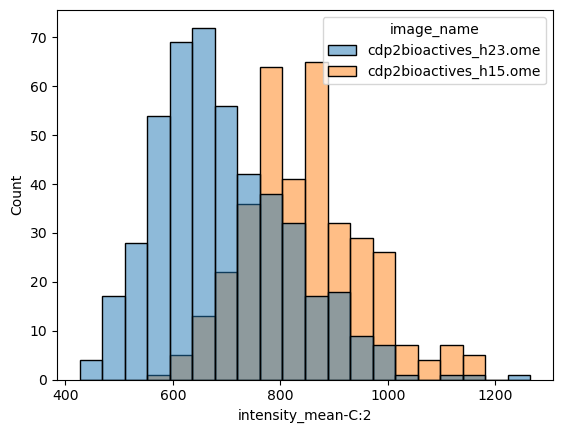

In [23]:
sns.histplot(data=summary_select,x='intensity_mean-C:2', hue='image_name');

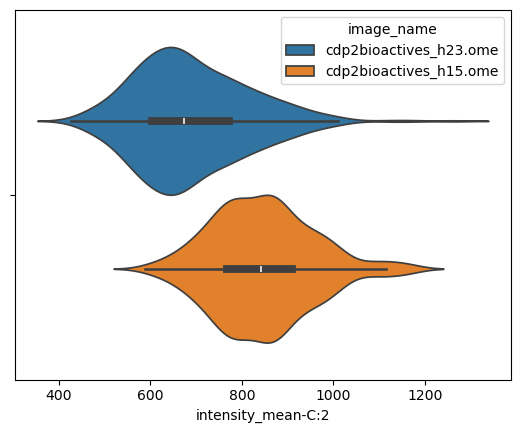

In [28]:
sns.violinplot(data=summary_select,x='intensity_mean-C:2', hue='image_name');

We can also compute statistical properties grouping by `image_name`:

In [29]:
summary_group = summary.groupby(by='image_name')

In [30]:
summary_group.median(numeric_only=True)

,area,intensity_mean-C:0,intensity_mean-C:1,intensity_mean-C:2,intensity_mean-C:3,intensity_mean-C:4,scene
image_name,,,,,,,
cdp2bioactives_h15.ome,2393.0,374.868567,827.291979,850.101290,1100.208651,555.278409,3.0
cdp2bioactives_h23.ome,2155.0,360.374968,653.158997,679.762017,1018.933699,524.962879,2.0
